# Role interpretation for regular equivalence

In [2]:
libs <- c(
  "dplyr",
  "tidyr",
  "forcats",
  "arrow",
  "igraph",
  "blockmodeling",
  "ggplot2",
  "svglite"
)
new.packages <- libs[!(libs %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
invisible(lapply(libs, library, character.only = TRUE))

Read graphs

In [3]:
types = c('replies', 'votes', 'follows')
gs = list()
n = 253
for (t in types) {
  gs[[t]] = read_graph(paste0('graphs/',t,'-',n,'.graphml'), format = 'graphml')
}

Read results and group assignments from blockmodelling

In [7]:
res_bm = readRDS(paste0('results/bm/', 'bm-', n, '-bin.rds'))
mem_bm = read.csv(paste0('results/bm/', 'membership-', n, '.csv'))
k_bm = list(replies = 3, votes = 3, follows = 4)

## Blockmodelling

### Inspect relationship between groups

Build graph of relationships between different equivalence classes

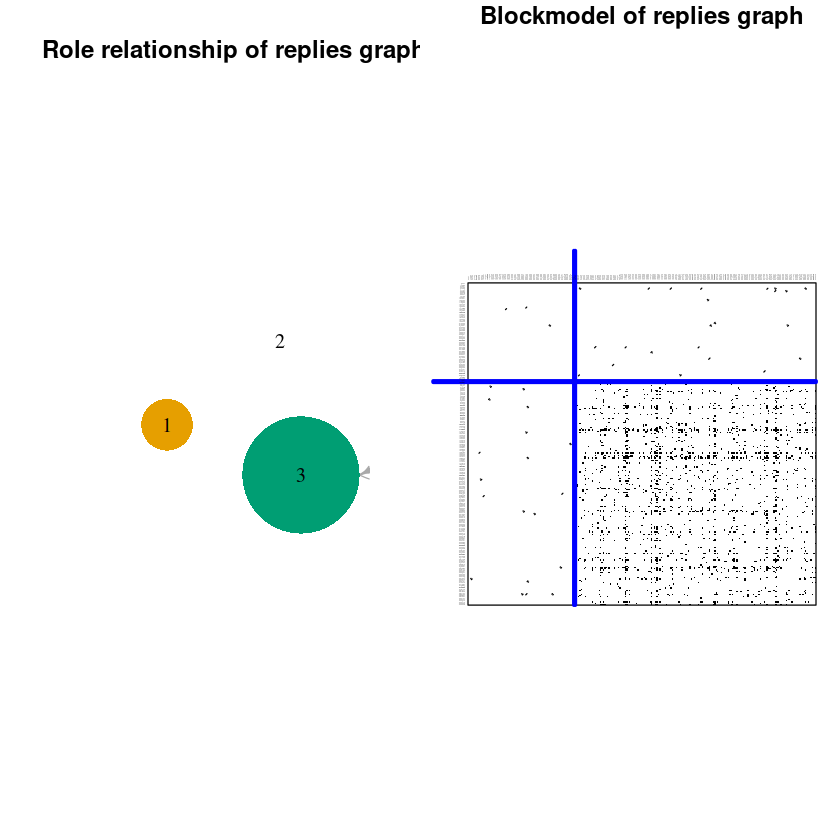

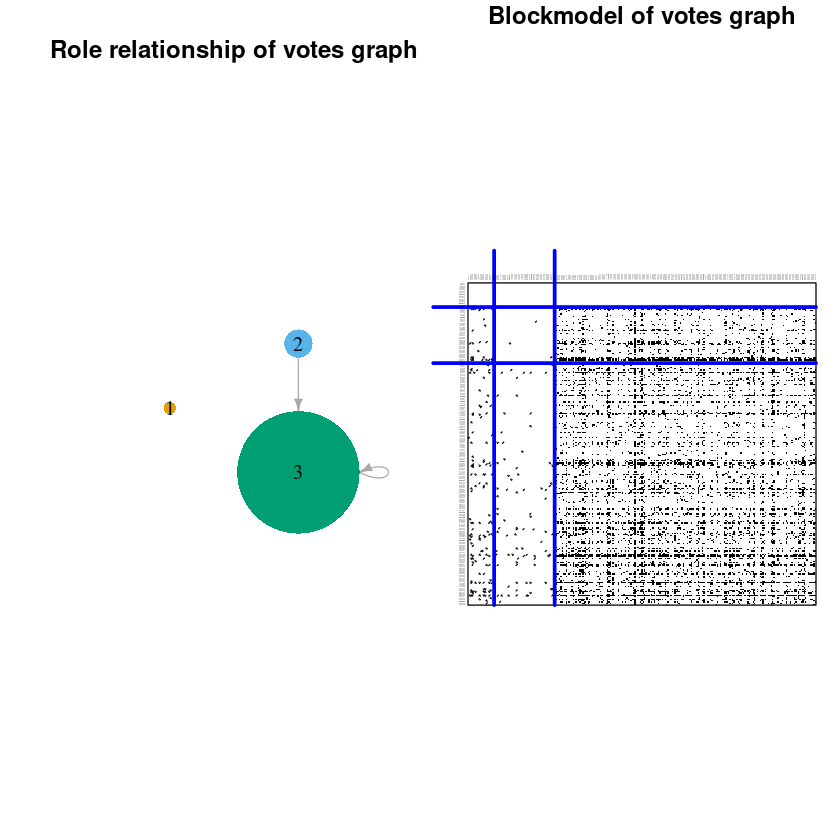

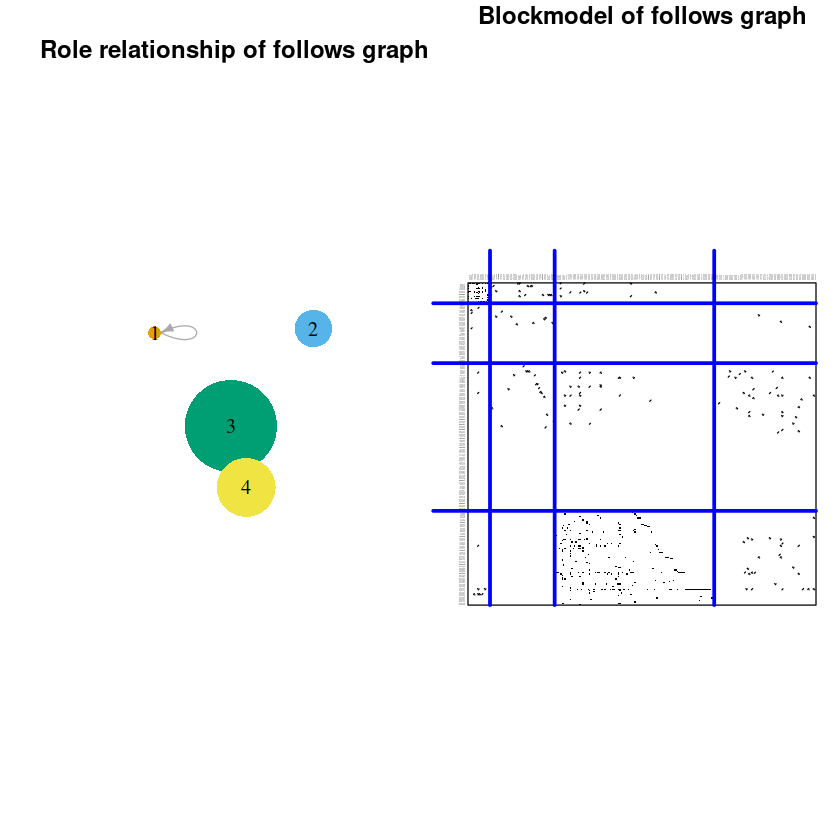

In [33]:
group_rel = list(3)
for (type in types) {
  A = IM(res_bm[[type]][[k_bm[[type]]]])

  A[A == 'com'] <- 1
  A[A == 'reg'] <- 1
  A[A == 'nul'] <- 0
  
  A = matrix(as.numeric(A), nrow = nrow(A), ncol = ncol(A))
  
  g <- graph_from_adjacency_matrix(A, mode = "directed", weighted = FALSE)
  
  group_col = paste0('group_', type)
  
  group_sizes = count(mem_bm, !!sym((group_col)))
  
  # png(paste0('results/bm/rel-', n, '-', type, '.png'), width = 800, height = 800)
  par(mfrow = c(1, 2))
  plot(g, layout = layout_with_fr(g, start.temp = vcount(g), maxx=rep(.1, vcount(g))),
       vertex.frame.width=0, vertex.color = V(g), vertex.size = group_sizes$n,vertex.label.color='black',
       edge.arrow.size = .5, loop.size = 1.5,
       main = paste('Role relationship of', type, 'graph')
  )
  plot(res_bm[[type]][[k_bm[[type]]]], main = paste('Blockmodel of', type, 'graph'),
      mar = c(1, 2, 3, 1), title.line = 2)
  # dev.off()
  group_rel[[type]] = g

  # Add group membership to graph
  gs[[type]]$role_bm = clu(res_bm[[type]][[k_bm[[type]]]])
}

Visualise graph coloured by roles

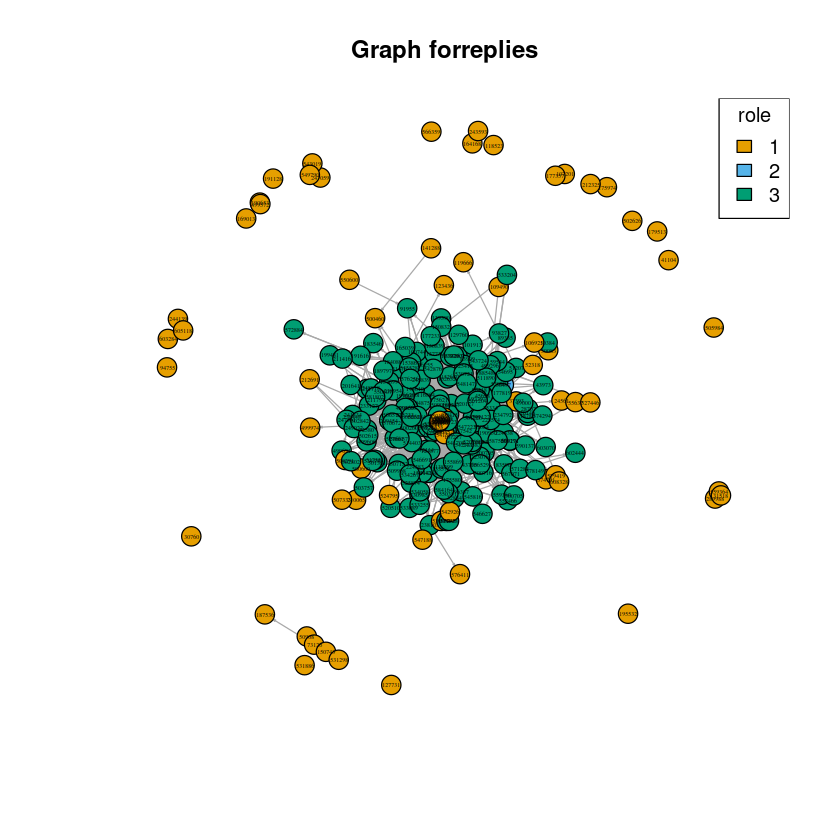

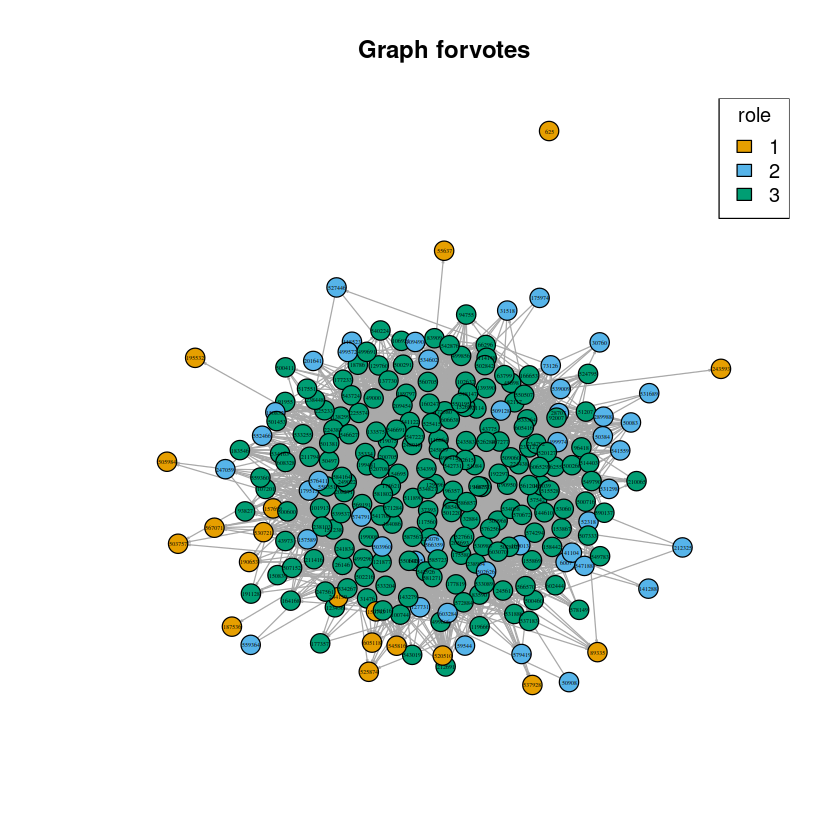

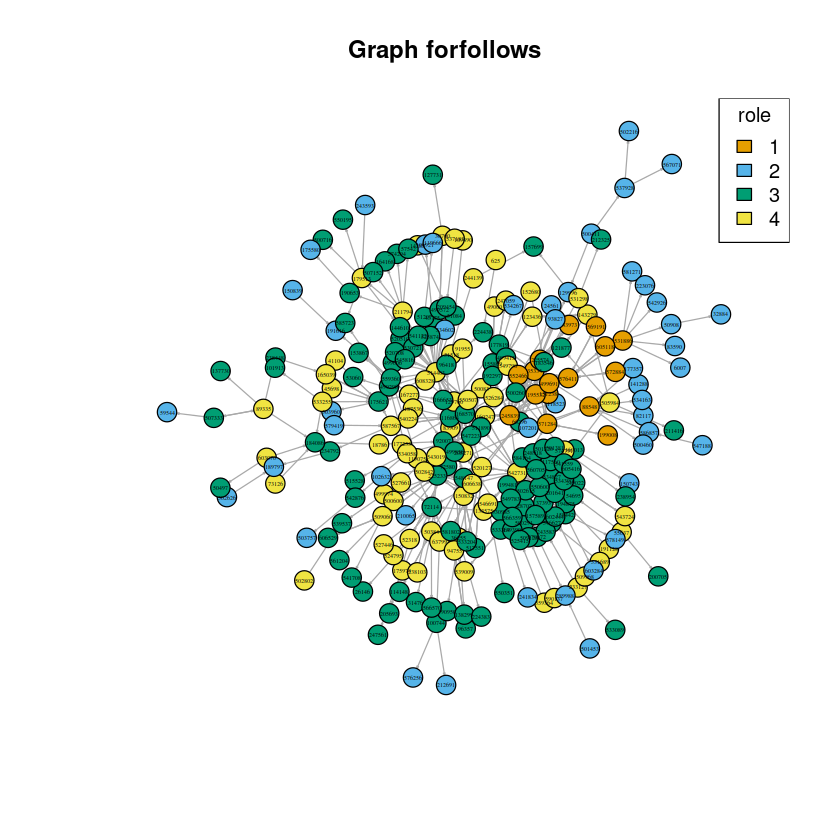

In [21]:
palette=categorical_pal(8)

for (t in types) {  
  # png(paste0("results/rege/graph-", type, ".png")) # output plot to file
  plot(gs[[t]], layout=layout_with_kk(gs[[t]]), main=paste0("Graph for",t),
              vertex.color=gs[[t]]$role_bm, palette=palette, vertex.label.cex=0.3, vertex.size=7, vertex.label.color = 'black', edge.arrow.size=0.1)
  legend("topright", legend = levels(factor(gs[[t]]$role_bm)), fill = palette, title = "role")
  # dev.off()
}

### Inpsect combinations of group membership of nodes across replying, voting, following behaviours


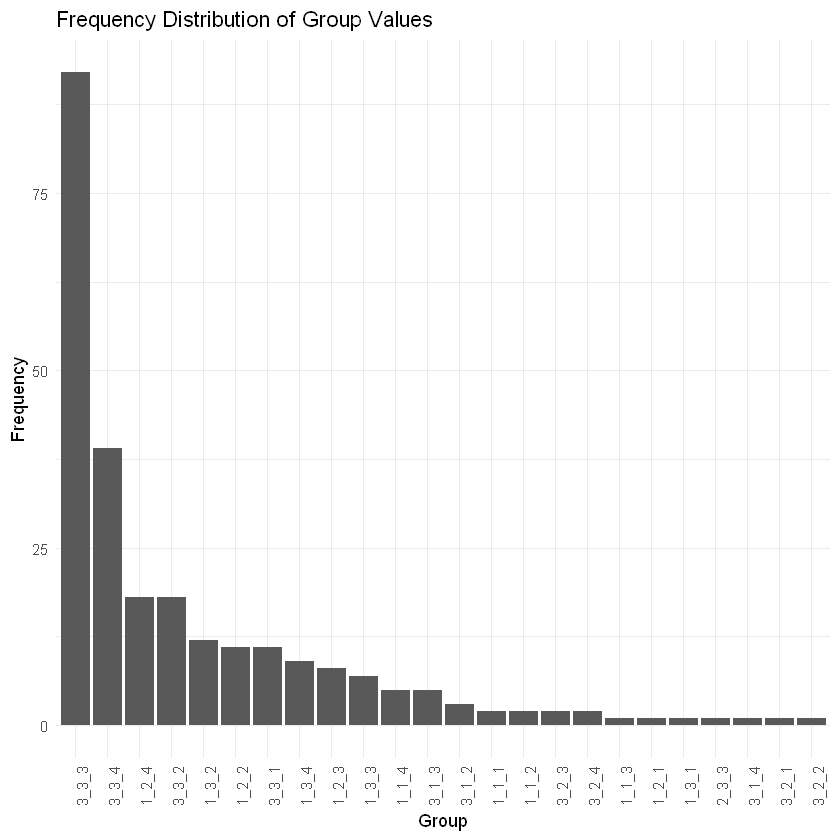

In [8]:
group_freq <- mem_bm %>%
  count(group)

# Plot the frequency distribution of the values in the 'group' column, sorted by frequency
ggplot(group_freq, aes(x = fct_reorder(group, n, .desc = TRUE), y = n)) +
  geom_bar(stat = 'identity') +
  labs(
    title = 'Frequency Distribution of Group Values',
    x = 'Group',
    y = 'Frequency'
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Inspect network properties by group

Calculate node level network properties

In [9]:
stats = list(3)

for (type in types) {
  group_col = paste0('group_', type)
  stat = mem_bm %>% select(name, group_col)
  stat = stat %>%
    mutate(
      indegree = degree(gs[[type]], mode = 'in'),
      outdegree = degree(gs[[type]], mode = 'out'),
      betweenness = betweenness(gs[[type]]),
      eigen = eigen_centrality(gs[[type]])$vector
    )
  stats[[type]] = stat
}
stats[['replies']] %>% head()


,name,group_replies,indegree,outdegree,betweenness,eigen
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,6007,1,0,0,0.00000,0.000000e+00
2,14285,1,0,0,0.00000,0.000000e+00
3,18786,3,2,3,27.59097,2.638781e-04
4,24561,1,1,0,0.00000,2.256246e-05
5,26146,3,3,6,101.45094,6.222937e-04
6,28707,3,4,2,69.16601,2.529128e-03


Saving 7 x 7 in image


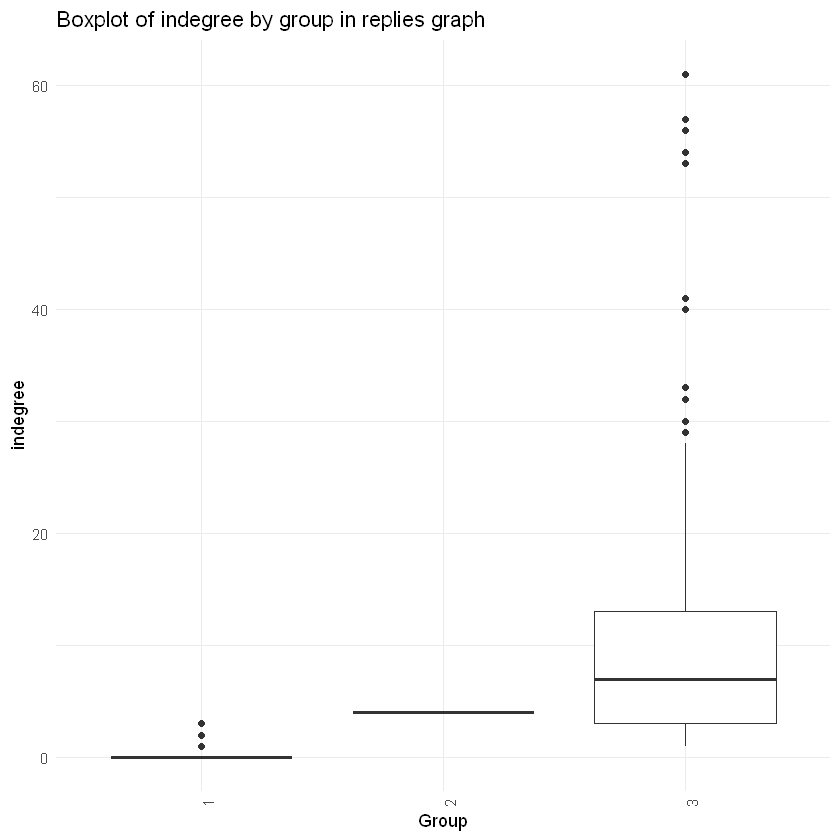

Saving 7 x 7 in image


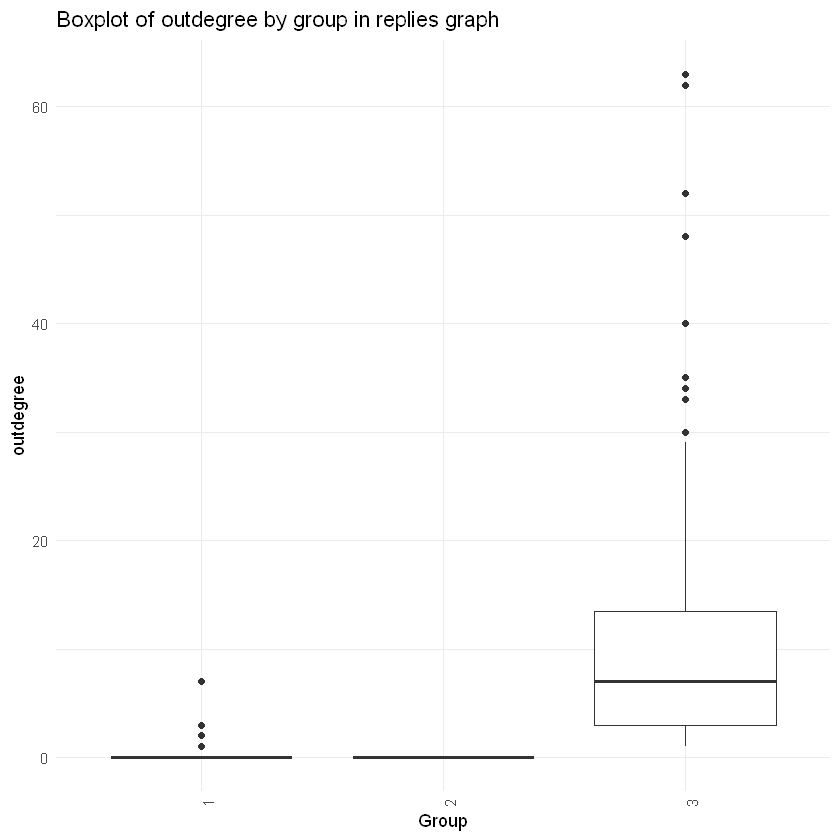

Saving 7 x 7 in image


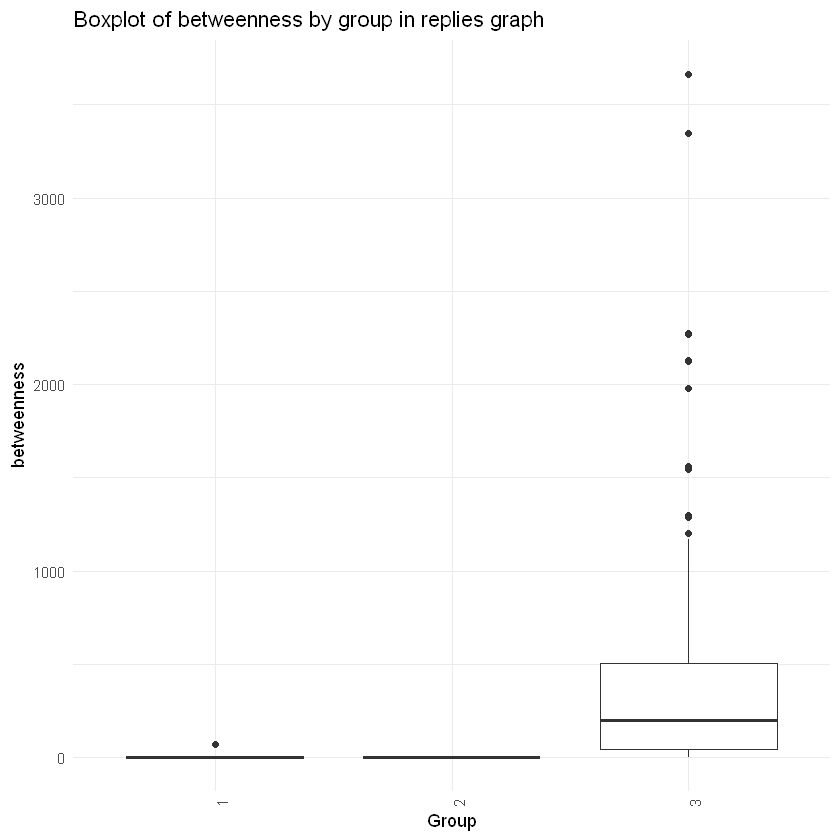

Saving 7 x 7 in image


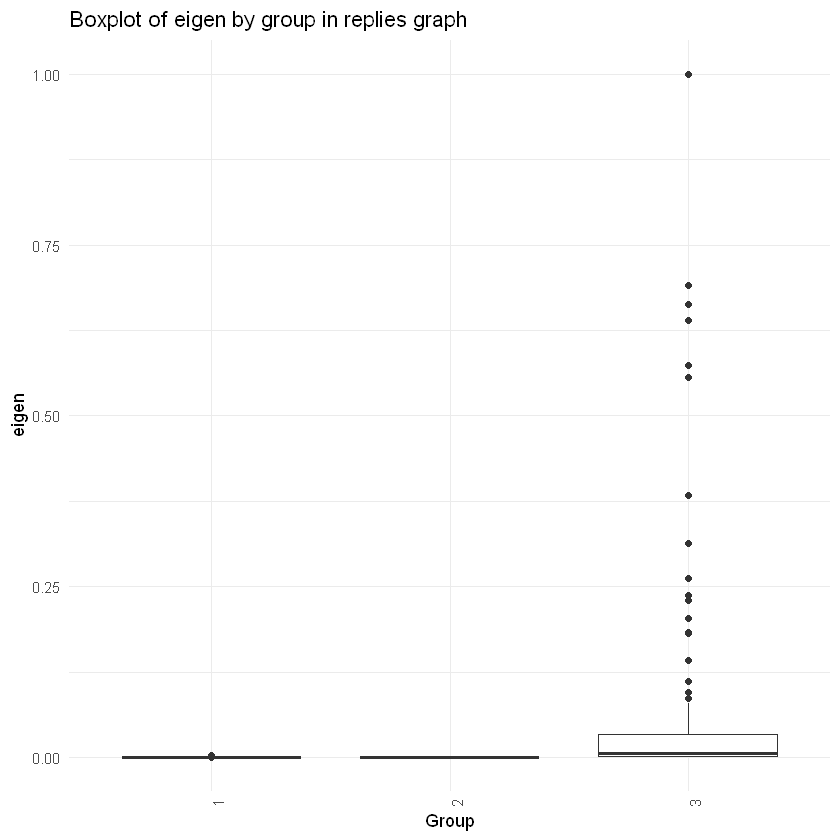

Saving 7 x 7 in image


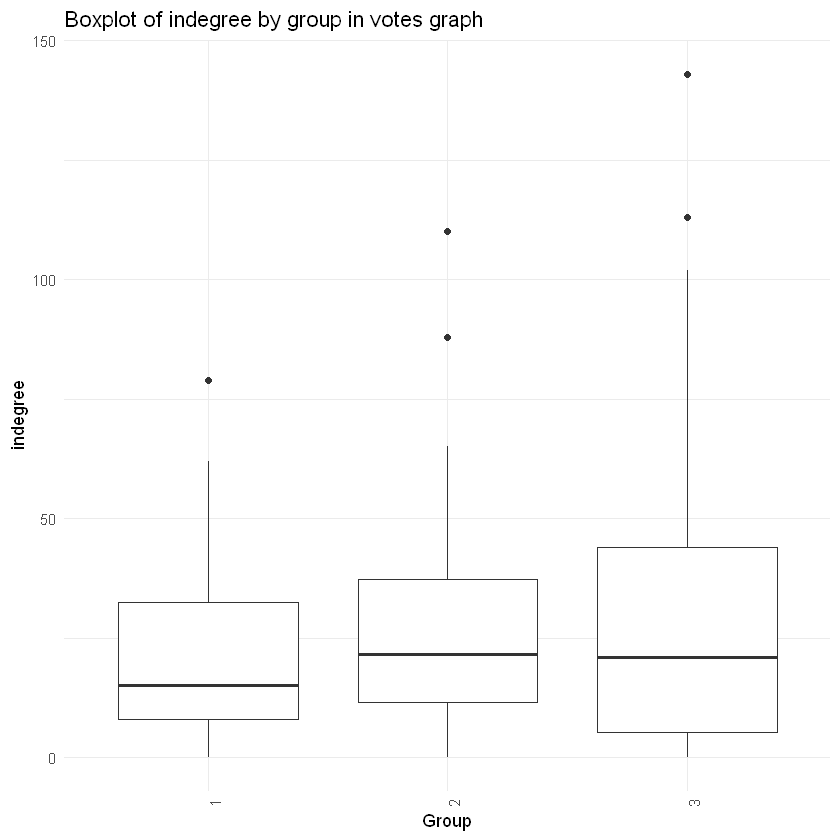

Saving 7 x 7 in image


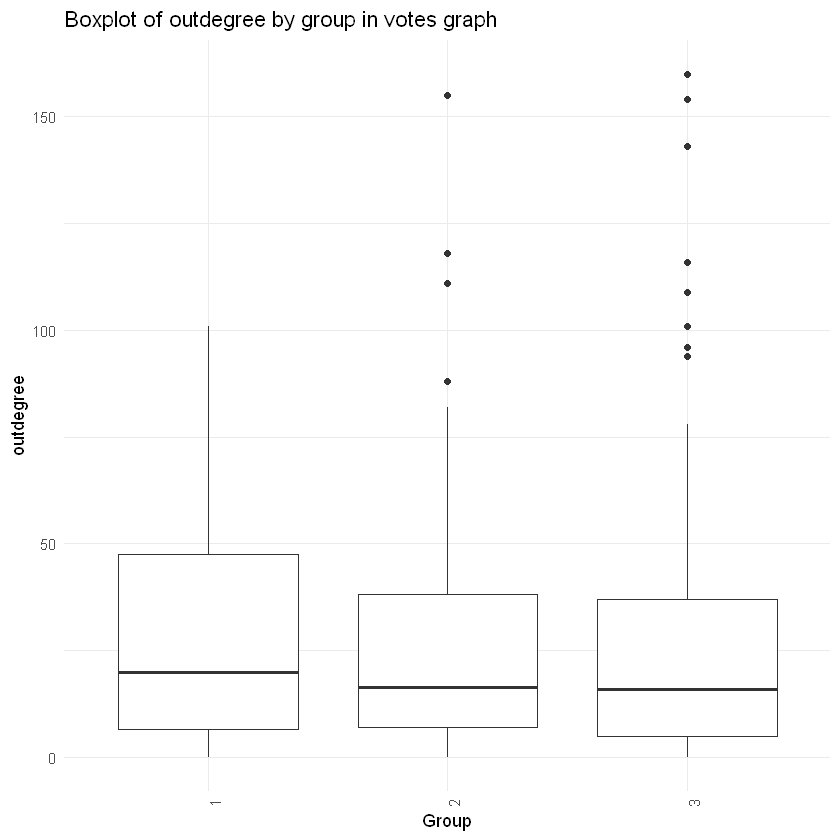

Saving 7 x 7 in image


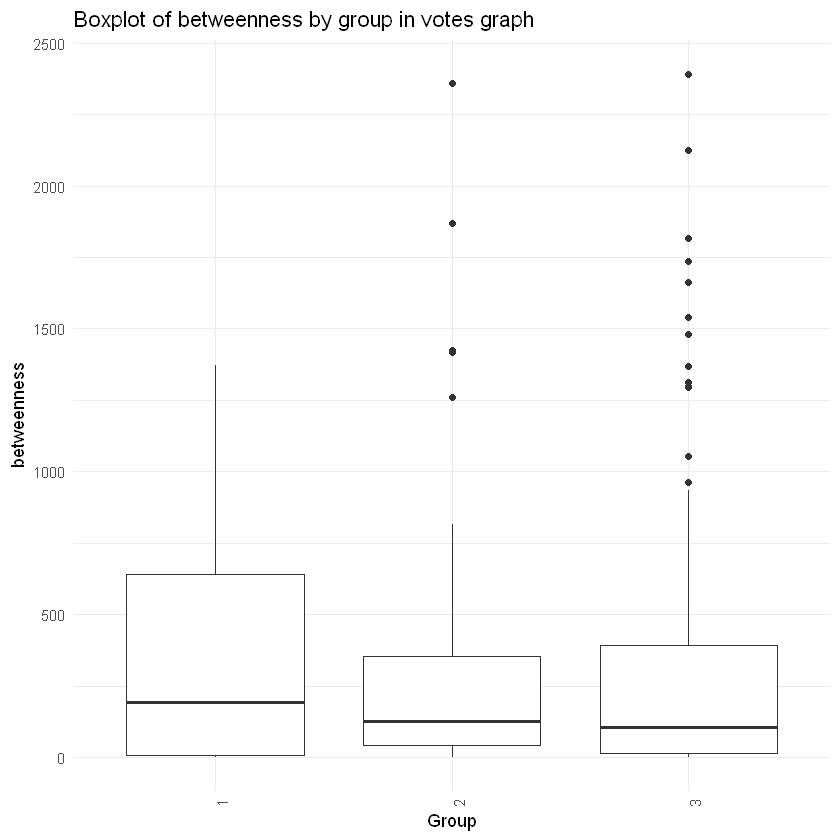

Saving 7 x 7 in image


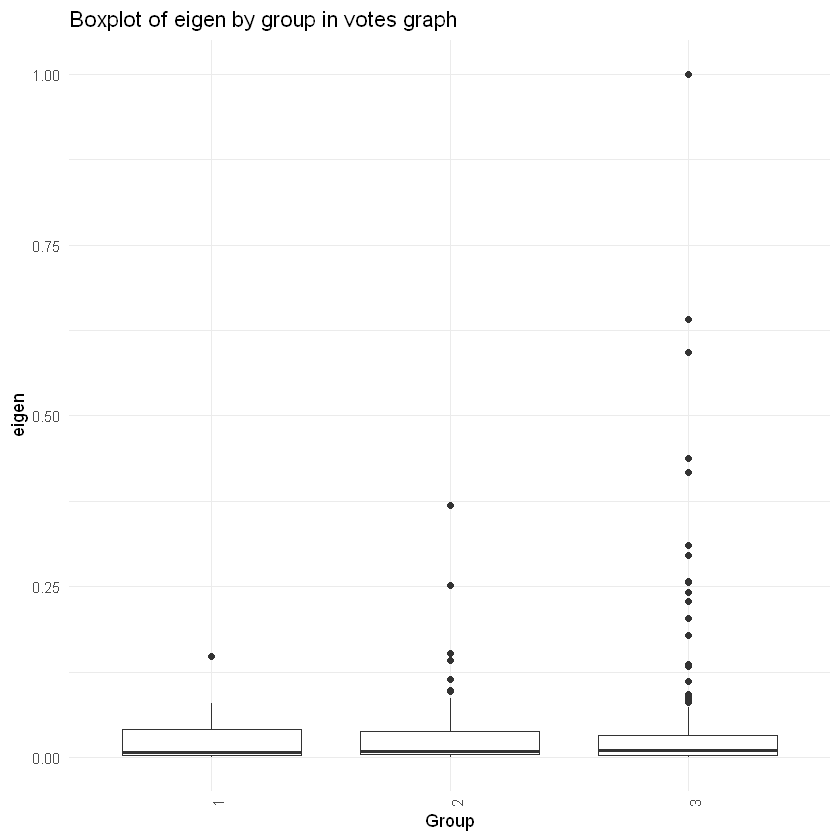

Saving 7 x 7 in image


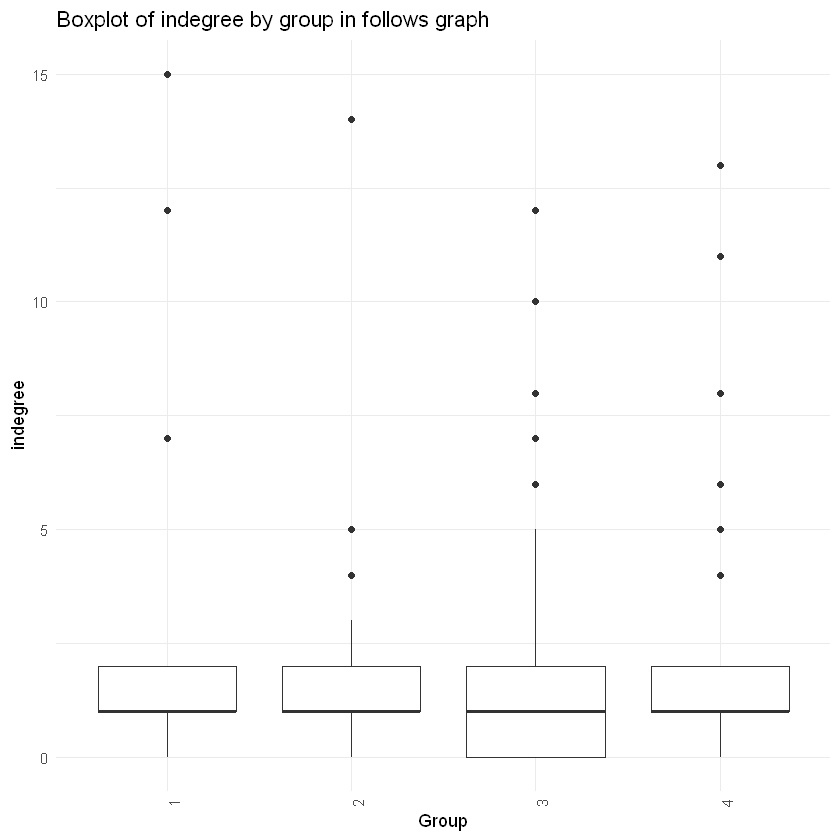

Saving 7 x 7 in image


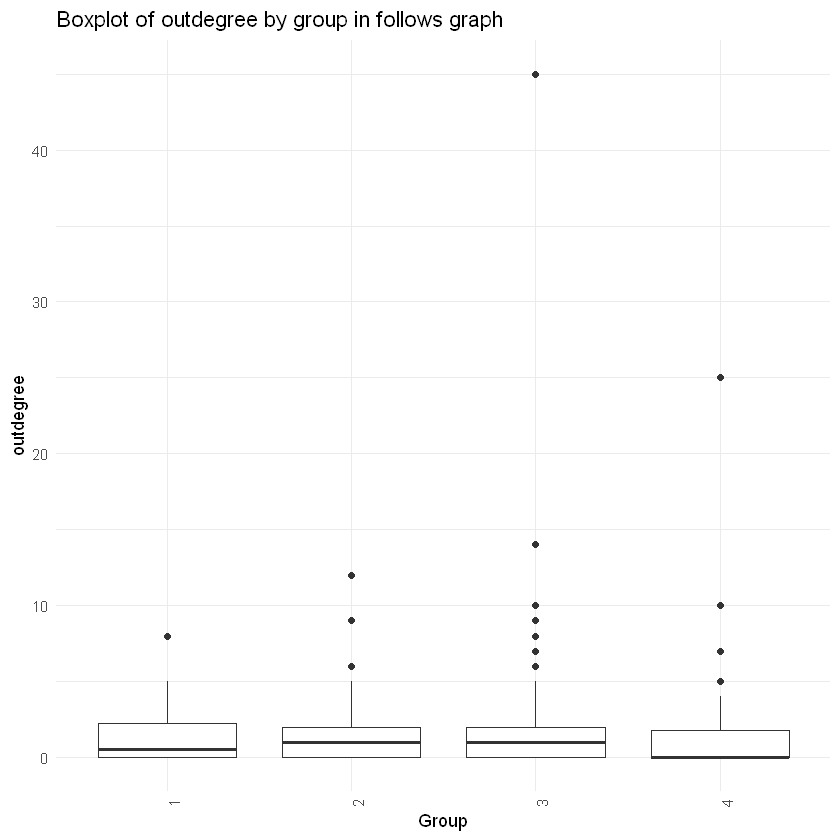

Saving 7 x 7 in image


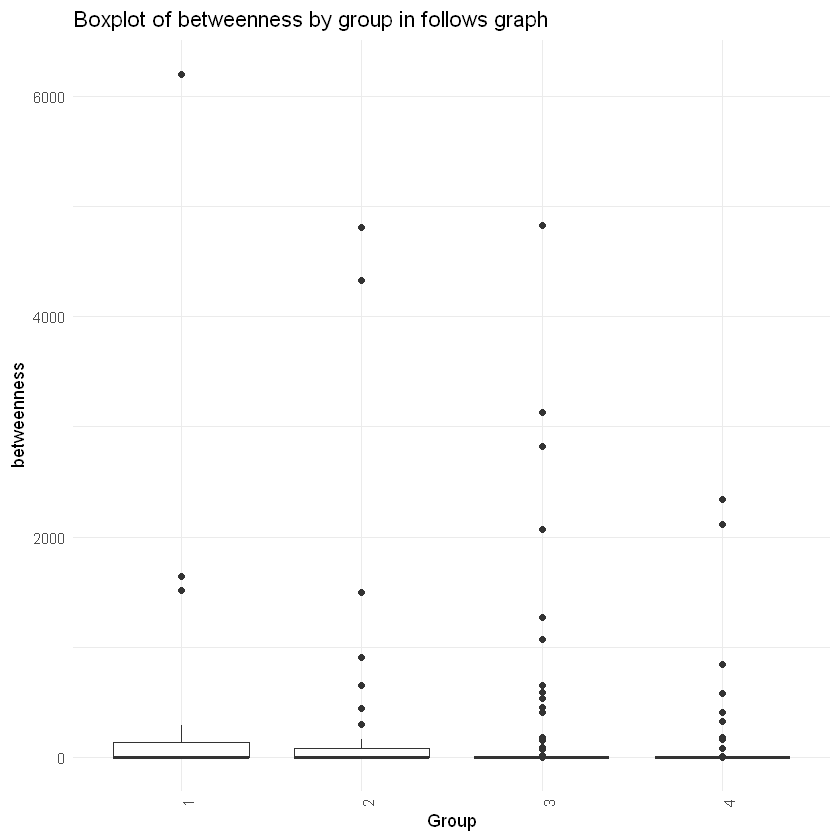

Saving 7 x 7 in image


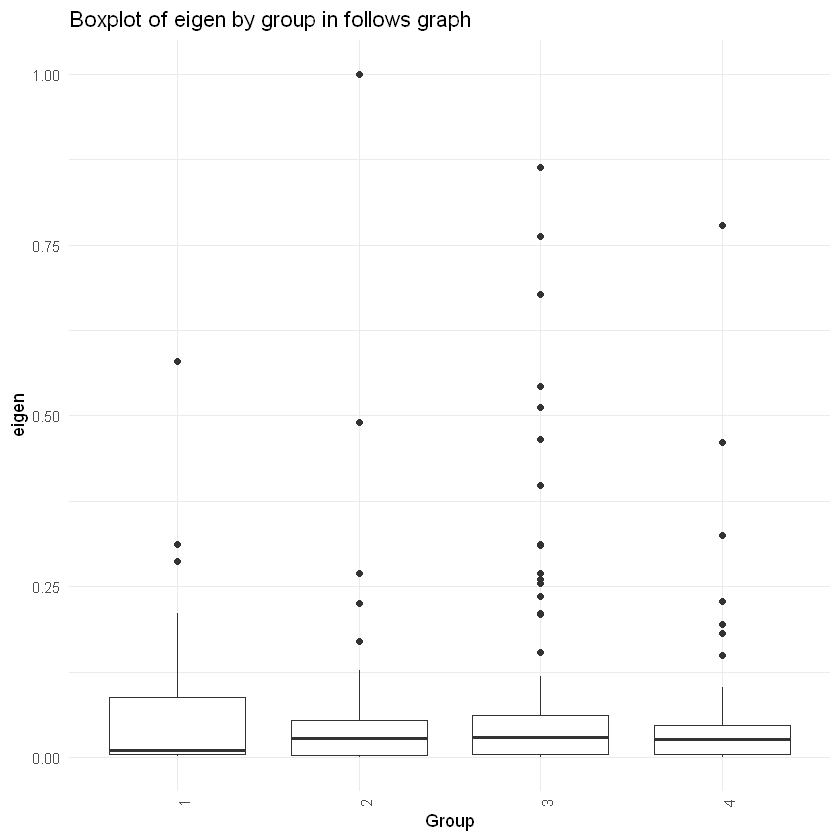

In [10]:
for (type in types) {
  x = paste0('group_', type)
  for (col in c('indegree', 'outdegree', 'betweenness', 'eigen')) {
    p = ggplot(stats[[type]], aes(x = as.factor(.data[[x]]), y = .data[[col]])) +
      geom_boxplot() +
      labs(
        title = paste('Boxplot of', col, 'by group in', type, 'graph'),
        x = 'Group',
        y = col
      ) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
    ggsave(paste0('results/bm/', type, '-', n, '-', col, '.svg'))
  }
}


## REGE


